<a href="https://colab.research.google.com/github/rennyatwork/CegepSteFoy_IA/blob/main/08_deep_learning/tp_01_v06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
#import tensorflow.keras.optimizers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.wrappers.scikit_learn import KerasRegressor
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
import keras as keras
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np
from keras.callbacks import ModelCheckpoint
import seaborn as sns
from sklearn import linear_model
from sklearn.dummy import DummyRegressor
from sklearn import metrics
import math
from tensorflow.keras.regularizers import l2

In [ ]:
#!pip install tensorflow

In [3]:
## column to predict
y_col = 'TotalScore'

In [4]:
def get_df_from_csv(p_path, p_sep=',', p_print=True):
  df= pd.read_csv(p_path, sep= p_sep)
  if (p_print):
    print('---Head---')
    print(df.head())
    print('-- How many nulls? --')
    print(df.isna().sum())
  return df


In [5]:
## Augmented df
def get_augmented_df():
  ## head 400001
  path_csv = "https://raw.githubusercontent.com/rennyatwork/CegepSteFoy_IA/main/08_deep_learning/data/AugmentedData_reduced.csv"
  augmented_df_1 = get_df_from_csv(path_csv, p_sep =",")
  ## tail 284000
  path_csv = "https://raw.githubusercontent.com/rennyatwork/CegepSteFoy_IA/main/08_deep_learning/data/AugemntedData_reduced_tail.csv"
  augmented_df_2 = get_df_from_csv(path_csv, p_sep =",")

  return pd.concat([augmented_df_1, augmented_df_2])

In [6]:
## augmented_df (full augmented_df)
augmented_df = get_augmented_df()

---Head---
   GameID  ScenarioID  HolesCompletedCount  Hole1  Hole2  Hole3  Hole4  Hole5  \
0       1           1                    0      0      0      0      0      0   
1       2           1                    0      0      0      0      0      0   
2       3           1                    0      0      0      0      0      0   
3       4           1                    0      0      0      0      0      0   
4       5           1                    0      0      0      0      0      0   

   Hole6  Hole7  ...  Hole10  Hole11  Hole12  Hole13  Hole14  Hole15  Hole16  \
0      0      0  ...       0       0       0       0       0       0       0   
1      0      0  ...       0       0       0       0       0       0       0   
2      0      0  ...       0       0       0       0       0       0       0   
3      0      0  ...       0       0       0       0       0       0       0   
4      0      0  ...       0       0       0       0       0       0       0   

   Hole17  Hole18  To

In [7]:
## nulls?
print(augmented_df.isnull().sum())
print(augmented_df[y_col].mode())


GameID                 283999
ScenarioID             283999
HolesCompletedCount    283999
Hole1                  283999
Hole2                  283999
Hole3                  283999
Hole4                  283999
Hole5                  283999
Hole6                  283999
Hole7                  283999
Hole8                  283999
Hole9                  283999
Hole10                 283999
Hole11                 283999
Hole12                 283999
Hole13                 283999
Hole14                 283999
Hole15                 283999
Hole16                 283999
Hole17                 283999
Hole18                 283999
TotalScore             283999
1                      400000
201                    400000
10                     400000
4                      400000
6                      400000
0                      400000
0.1                    400000
0.2                    400000
0.3                    400000
0.4                    400000
0.5                    400000
0.6       

In [7]:
### several nulls...
### Let's create a function to replace nulls with most frequent values

def get_df_without_nulls(p_df):
  for col in p_df.columns:
    most_frequent_value = p_df[col].mode()[0]
    p_df[col].fillna(most_frequent_value, inplace=True)
  return p_df


In [8]:
#### still any nulls?
augmented_df2 = get_df_without_nulls(augmented_df)

print(augmented_df2.isnull().sum())
print(augmented_df2[y_col].mode())

GameID                 0
ScenarioID             0
HolesCompletedCount    0
Hole1                  0
Hole2                  0
Hole3                  0
Hole4                  0
Hole5                  0
Hole6                  0
Hole7                  0
Hole8                  0
Hole9                  0
Hole10                 0
Hole11                 0
Hole12                 0
Hole13                 0
Hole14                 0
Hole15                 0
Hole16                 0
Hole17                 0
Hole18                 0
TotalScore             0
1                      0
201                    0
10                     0
4                      0
6                      0
0                      0
0.1                    0
0.2                    0
0.3                    0
0.4                    0
0.5                    0
0.6                    0
0.7                    0
5                      0
4.1                    0
4.2                    0
6.1                    0
4.3                    0


In [9]:
## Original df
path_csv = "https://raw.githubusercontent.com/rennyatwork/CegepSteFoy_IA/main/08_deep_learning/data/OriginalData.csv"
original_df = get_df_from_csv(path_csv, p_sep =",")

---Head---
   GameID  Hole1  Hole2  Hole3  Hole4  Hole5  Hole6  Hole7  Hole8  Hole9  \
0       1      4      6      5      4      6      5      5      3      5   
1       2      3      5      4      4      5      5      6      3      4   
2       3      5      4      6      4      7      4      5      3      5   
3       4      4      4      7      3      6      4      4      4      5   
4       5      4      7      6      4      5      4      5      3      4   

   Hole10  Hole11  Hole12  Hole13  Hole14  Hole15  Hole16  Hole17  Hole18  \
0       4       5       4       4       6       4       5       4       6   
1       5       5       5       4       5       3       4       3       4   
2       6       6       5       4       5       3       5       3       3   
3       7       5       7       4       6       3       6       3       4   
4       6       9       6       3       5       4       5       3       4   

   TotalScore  
0          85  
1          77  
2          83  
3    

In [11]:
## nulls?
original_df.isna().sum()

GameID        0
Hole1         0
Hole2         0
Hole3         0
Hole4         0
Hole5         0
Hole6         0
Hole7         0
Hole8         0
Hole9         0
Hole10        0
Hole11        0
Hole12        0
Hole13        0
Hole14        0
Hole15        0
Hole16        0
Hole17        0
Hole18        0
TotalScore    0
dtype: int64

In [10]:
## most frequent value?
print(original_df[y_col].mode())
print(original_df[y_col].mean())

0    83
Name: TotalScore, dtype: int64
83.0655


In [ ]:
## naïve prediction (baseline) can be original_df[y_col].mode(), original_df[y_col].mean()

In [11]:
## train test split
## we apply the scaler
def get_train_test(pDf=original_df, p_var_y=y_col, p_test_size=0.2, p_random_state=25):
  dfX = pDf.drop(p_var_y, axis=1).values
  dfY = pDf[p_var_y]

  # Apply standardization to feature values
  scaler = StandardScaler()
  dfX_standardized = scaler.fit_transform(dfX)

  X_train, X_test, y_train, y_test = train_test_split(dfX, dfY, test_size=p_test_size, random_state=p_random_state)
  X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=p_test_size, random_state=p_random_state)

  return X_train, X_valid, X_test, y_train, y_valid, y_test


########## Establishing a baseline #########

In [12]:
def analyze_dummy(p_df, p_X_train, p_X_valid, p_y_train ,p_y_valid):
  baseline_reg = DummyRegressor()
  baseline_reg.fit(p_X_train, p_y_train)
  print("[score train]", baseline_reg.score(p_X_train, p_y_train))
  print("[score valid]", baseline_reg.score(p_X_valid, p_y_valid))

  y_pred = baseline_reg.predict(p_y_valid)

  print('Root Mean Squared Error - [RMSE]:', round(np.sqrt(metrics.mean_squared_error(p_y_valid, y_pred)),3) )
  print('Mean Squared Error - [MSE]:', round(metrics.mean_squared_error(p_y_valid, y_pred),3) )



In [15]:
## augmented_df
X_train, X_valid, X_test, y_train, y_valid, y_test = get_train_test(augmented_df2)
analyze_dummy(augmented_df2, X_train, X_valid, y_train, y_valid)

[score train] 0.0
[score valid] -2.5220723929519906e-05
Root Mean Squared Error - [RMSE]: 5.351
Mean Squared Error - [MSE]: 28.635


In [14]:
## original df
X_train, X_valid, X_test, y_train, y_valid, y_test = get_train_test(original_df)
analyze_dummy(original_df, X_train, X_valid, y_train, y_valid)

[score train] 0.0
[score valid] -0.000796875625000304
Root Mean Squared Error - [RMSE]: 7.06
Mean Squared Error - [MSE]: 49.844


#############################

Our model must perform better than

Mean Squared Error - [MSE]: 28.635

#############################


####### Simple regression ######


In [ ]:
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.model_selection import cross_val_score

In [ ]:
### affiche les metriques
def print_metrics(pY, pYpred, nbDecimal=3 ):
    #print('Mean Absolute Error - [MAE]:', round(metrics.mean_absolute_error(pY, pYpred), nbDecimal) )
    print('Mean Squared Error - [MSE]:', round(metrics.mean_squared_error(pY, pYpred),nbDecimal ) )
    #print('Score - [accuracy]: ', round(pRegressor.score(pY, pYpred), nbDecimal))
    print('Root Mean Squared Error - [RMSE]:', round(np.sqrt(metrics.mean_squared_error(pY, pYpred)),nbDecimal) )
    #print('[Classification report]')
    #print(classification_report(pYtest, pYpred, labels = donnee['ozone'].unique()))


In [ ]:
from sklearn.model_selection import LeaveOneOut
def analyze_regression(p_X_train,
                       p_X_test,
                       p_y_train,
                       p_y_test,
                       pCv=4,
                       pMaxIter=1000
                       ):



    print("-----[Linear Regression]-----")
    regr = linear_model.LinearRegression(fit_intercept=True)
    regr.fit(p_X_train, p_y_train)



    loo = LeaveOneOut()
    #print(loo.get_n_splits(X))
    #crossvalidation = KFold(n_splits=392, random_state=None, shuffle=False)

    ##http://www.science.smith.edu/~jcrouser/SDS293/labs/lab7-py.html
    scores_train = cross_val_score(regr, p_X_train, p_y_train, cv=loo, scoring="neg_mean_squared_error")
    mse_train = np.mean(np.abs(scores_train))
    print("---[train]---")
    #print("[train] -   MSE: " + str(mse_train) + ", STD: " + str(np.std(scores_train)))
    print("RMSE ", round(np.sqrt(mse_train),3) )
    print("MSE ", round(mse_train,3))
    #print("score ", round(np.std(scores_train),3) )


    scores_test = cross_val_score(regr, p_X_test, p_y_test, cv=loo, scoring="neg_mean_squared_error")
    mse_test = np.mean(np.abs(scores_test))
    print("---[test]---")
    #print("[test] -   MSE: " + str(mse_test) + ", STD: " + str(np.std(scores_test)))
    print("RMSE ", round(np.sqrt(mse_test),5 ))
    print("MSE ", round(mse_test,5))
    #print("score ", round(np.std(scores_test),3) )


    y_pred_train = regr.predict(p_X_train)
    y_pred_test = regr.predict(p_X_test)

    print("---[train]---")
    print_metrics(p_y_train, y_pred_train)

    print("---[test]---")
    #print("[score]: ",  regr.score(X_test, y_test))
    print_metrics(p_y_test, y_pred_test)



In [ ]:
## regression
analyze_regression(p_X_train = X_train,
                       p_X_test = X_valid,
                       p_y_train = y_train,
                       p_y_test = y_valid,
                   pMaxIter=5)

-----[Linear Regression]-----


KeyboardInterrupt: ignored

In [ ]:
### elasticnet, ridge, lasso
def analyze_regularization(
                    pAlphas
                    , pRegressorName
                    , pRegressorCVName
                    , p_X_train
                    , p_X_test
                    , p_y_train
                    , p_y_test
                    , pCv=5
                    , pMaxIter=5
                    ):



    print("----["+pRegressorName+"]----")
    regr = globals()[pRegressorCVName](alphas=pAlphas, cv=pCv).fit(p_X_train, p_y_train)
    #regr = linear_model.ElasticNetCV(alphas=pAlphas, cv=pCv).fit(X_train, y_train)

    print("[alpha]: ", regr.alpha_)

    modele_final = globals()[pRegressorName](regr.alpha_, max_iter=pMaxIter).fit(p_X_train, p_y_train)

    y_pred_train = regr.predict(p_X_train)
    y_pred_test = regr.predict(p_X_test)


    print("---[train]---")
    print_metrics(p_y_train, y_pred_train)

    print("---[test]---")
    #print("[score]: ",  regr.score(X_test, y_test))
    print_metrics(p_y_test, y_pred_test)

In [ ]:
type(original_df)

pandas.core.frame.DataFrame

In [ ]:
### Ridge avec var exponnentielles
lstAlpha = [0.5, 0.8, 1, 1.2, 1.3]
#analyze_ridge(powerDfX, dfY, lstAlpha)
#lstAlpha = [  7, 8, 8.4, 8.5, 8.6,  10, 10.5]
analyze_regularization( lstAlpha
                       , pRegressorName = "Ridge"
                       , pRegressorCVName = "RidgeCV"
                       , p_X_train = X_train
                       , p_X_test = X_valid
                       , p_y_train = y_train
                       , p_y_test = y_valid
                      )

----[Ridge]----
[alpha]:  0.5
---[train]---
Mean Squared Error - [MSE]: 0.0
Root Mean Squared Error - [RMSE]: 0.001
---[test]---
Mean Squared Error - [MSE]: 0.0
Root Mean Squared Error - [RMSE]: 0.001


###################


In [16]:
## create model
def create_model (p_learning_rate, p_dropout_rate, pDfX, p_nb_neuron_input=128, p_activation='relu', p_batch_norm=False):
  model = None
  model = Sequential()
  model.add(Dense(p_nb_neuron_input, input_dim=pDfX.shape[1], activation=p_activation))
  model.add(Dropout(p_dropout_rate))
  if (p_batch_norm):
    model.add(keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5))

  model.add(Dense(int(p_nb_neuron_input/2), activation=p_activation))
  model.add(Dropout(p_dropout_rate))
  if (p_batch_norm):
    model.add(keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5))

  model.add(Dense(int(p_nb_neuron_input/4), activation=p_activation))
  model.add(Dropout(p_dropout_rate))
  if (p_batch_norm):
    model.add(keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5))

  model.add(Dense(1))

  adam = Adam(lr = p_learning_rate)

  #model.compile( loss='mean_squared_error', optimizer=adam, metrics=['mae'])
  model.compile( loss='mean_squared_error', optimizer=adam, metrics=['mse'])
  return model


In [17]:
## build model (book HandsOn -on ML, Aurélien Géron)
def build_model (p_input_shape,
                 p_n_hidden=1,
                 p_n_neurons=30,
                 p_learning_rate=3e-3,
                 p_activation='relu',
                 p_debug=True,
                 p_dropout_rate=0.4,
                 p_batch_norm=False):

  if p_debug:
    print("\r\n------[build_model]------")
    print("[p_input_shape]: ", p_input_shape )
    print("[p_n_hidden]: ", p_n_hidden )
    print("[p_n_neurons]: ", p_n_neurons )
    print("[p_learning_rate]: ", p_learning_rate )


  model = Sequential()
  model.add(keras.layers.InputLayer(input_shape=p_input_shape))
  for layer in range(p_n_hidden):
    model.add(keras.layers.Dense(p_n_neurons, activation=p_activation, kernel_regularizer=l2(0.01)))
    model.add(Dropout(p_dropout_rate))

    if (p_batch_norm):
      model.add(keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5))

    if p_n_hidden >1:
      print('---build_model, for layer in range(p_n_hidden)---')
      print('[p_n_neurons]: ', p_n_neurons)
      p_n_neurons =  int(math.sqrt(p_n_neurons))

    #keras.layers.BatchNormalization()
  model.add(Dropout(p_dropout_rate))
  model.add(keras.layers.Dense(1))
  optimizer = keras.optimizers.SGD(lr=p_learning_rate)

  #arr_metrics = ['mae', 'accuracy']
  #arr_metrics = ['mae']
  arr_metrics = ['mse']

  model.compile(loss='mse', optimizer = optimizer, metrics=arr_metrics)
  return model

In [18]:
## augmented_df
## getting train, test sets
X_train, X_valid, X_test, y_train, y_valid,  y_test = get_train_test(augmented_df2)

In [ ]:
## original_df
## getting train, test sets
X_train, X_valid, X_test, y_train, y_valid,  y_test = get_train_test(original_df)

In [ ]:
print(np.sum(np.isnan(X_train)))
print(np.sum(np.isnan(X_valid)))
print(np.sum(np.isnan(X_test)))
print(np.sum(np.isnan(y_train)))
print(np.sum(np.isnan(y_valid)))
print(np.sum(np.isnan(y_test)))

0
0
0
0
0
0


In [19]:
X_train.shape

(437759, 43)

In [20]:
def plot_graph_2(p_model_history, p_var_valid, p_var_test, p_arr_legend):
    # Plot MAE
    plt.plot(p_model_history[p_var_valid])
    plt.plot(p_model_history[p_var_test])

    ## Plot loss
    #plt.plot(p_model_history['loss'])
    #plt.plot(p_model_history['val_loss'])

    ## Add labels and legends for MAE and loss
    #plt.legend(['train MAE', 'test MAE', 'train loss', 'test loss'], loc='upper right')
    plt.legend(p_arr_legend, loc='upper right')
    plt.title('Model Metrics')
    plt.ylabel('Metrics')
    plt.xlabel('Epoch')
    plt.show()






In [22]:
def do_analysis(pModel, pXTrain, pYTrain, pXTest, pYTest,
                p_dropout_rate =0.3, p_learning_rate=0.01, p_epochs =30, p_batch_size=10,
                p_validation_split=0.2, p_verbose=True, p_plot_graph=1):

  ## we fit with train
  model_history = pModel.fit(pXTrain, pYTrain, batch_size=p_batch_size, epochs=p_epochs, validation_split = p_validation_split, verbose=1)

  ## we evaluate model's accuracy (use TEST vars, NOT TRAIN)
  score = pModel.evaluate(pXTest, pYTest, verbose=p_verbose)

  print("[Loss]: ", score[0])
  print("[MSE]: ", score[1])



  if(p_plot_graph):
    #plot_graph(model_history.history)
    #plot_graph_2(model_history.history, 'mae', 'val_mae', ['train MAE', 'test MAE'])
    plot_graph_2(model_history.history, 'mse', 'val_mse', ['train MSE', 'test MSE'])
    plot_graph_2(model_history.history, 'loss', 'val_loss', ['train LOSS', 'test LOSS'])


Epoch 1/2
35021/35021 [==============================] - 151s 4ms/step - loss: 368.2033 - mse: 368.2033 - val_loss: 431.3835 - val_mse: 431.3835
Epoch 2/2
35021/35021 [==============================] - 147s 4ms/step - loss: 129.3812 - mse: 129.3812 - val_loss: 24.5806 - val_mse: 24.5806
[Loss]:  24.651432037353516
[MSE]:  24.651432037353516


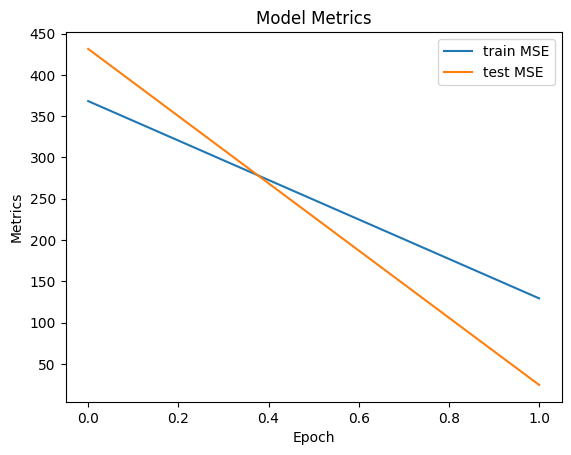

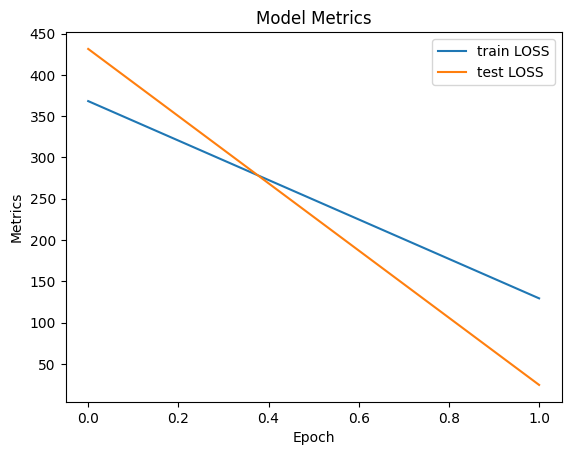

In [23]:
## Modele valuation
model = create_model (0.001, 0.3, X_train, p_batch_norm=False)
do_analysis(model, X_train, y_train, X_test
            , y_test, p_learning_rate =0.0001
            , p_epochs=20, p_verbose=0)

Epoch 1/15
35021/35021 [==============================] - 119s 3ms/step - loss: 143.3099 - mse: 143.3099 - val_loss: 1740.1941 - val_mse: 1740.1941
Epoch 2/15
35021/35021 [==============================] - 119s 3ms/step - loss: 28.5303 - mse: 28.5303 - val_loss: 1770.2959 - val_mse: 1770.2959
Epoch 3/15
35021/35021 [==============================] - 110s 3ms/step - loss: 28.5167 - mse: 28.5167 - val_loss: 37654752.0000 - val_mse: 37654752.0000
Epoch 4/15
35021/35021 [==============================] - 122s 3ms/step - loss: 28.5488 - mse: 28.5488 - val_loss: 121648640425984.0000 - val_mse: 121648640425984.0000
Epoch 5/15
35021/35021 [==============================] - 114s 3ms/step - loss: 28.6671 - mse: 28.6671 - val_loss: 2325089404059648.0000 - val_mse: 2325089404059648.0000
Epoch 6/15
35021/35021 [==============================] - 111s 3ms/step - loss: 28.3101 - mse: 28.3101 - val_loss: 28.2739 - val_mse: 28.2739
Epoch 7/15
35021/35021 [==============================] - 119s 3ms/step 

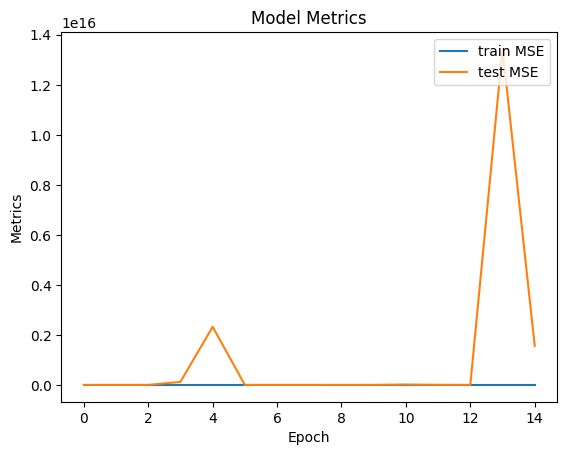

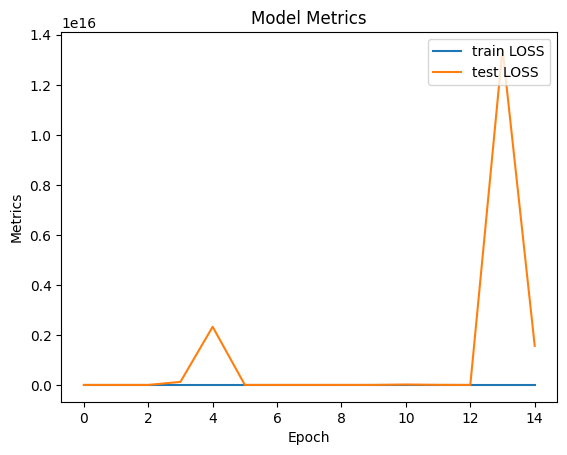

In [36]:
## Modele valuation
model = create_model (0.001, 0.3, X_train, p_batch_norm=True)
do_analysis(model, X_train, y_train, X_test
            , y_test, p_learning_rate =0.0001
            , p_epochs=15, p_verbose=0)

In [24]:
# Split your data and define input_shape
input_shape = X_train.shape[1]  # Number of features

# Create the KerasRegressor with your build_model function
keras_reg = KerasRegressor(build_fn=build_model
                           , p_input_shape=input_shape
                           , p_n_hidden=3
                           , p_n_neurons=input_shape*2
                           , p_learning_rate=3e-3
                           , p_activation='relu'
                           , p_dropout_rate=0.5
                           , p_batch_norm=True)

keras_reg.fit( X_train, y_train, epochs = 3,
              validation_data=(X_valid, y_valid),
              callbacks=[keras.callbacks.EarlyStopping(patience=3)])

msa_test = keras_reg.score(X_test, y_test)
y_pred = keras_reg.predict(X_test)

# Calculate Mean Squared Error (MSE)
print('y_test: ', y_test.isna().sum())
dfYPred = pd.DataFrame(y_pred)
print('y_pred: ', dfYPred.isna().sum())
mse = mean_squared_error(y_test, y_pred)
mse_test = -msa_test

# Calculate R-squared (Coefficient of Determination)
r2 = r2_score(y_test, y_pred)

print("[MSE] Mean Squared Error:", mse)
print("[MSE test] Mean Squared Error:", mse_test)
print("R-squared:", r2)

<ipython-input-24-829a9e6e3871>:5: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = KerasRegressor(build_fn=build_model
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)



------[build_model]------
[p_input_shape]:  43
[p_n_hidden]:  3
[p_n_neurons]:  86
[p_learning_rate]:  0.003
---build_model, for layer in range(p_n_hidden)---
[p_n_neurons]:  86
---build_model, for layer in range(p_n_hidden)---
[p_n_neurons]:  9
---build_model, for layer in range(p_n_hidden)---
[p_n_neurons]:  3
Epoch 1/3
13680/13680 [==============================] - 76s 5ms/step - loss: 71.7945 - mse: 71.1726 - val_loss: 28.8952 - val_mse: 28.6489
Epoch 2/3
13680/13680 [==============================] - 77s 6ms/step - loss: 28.9008 - mse: 28.7798 - val_loss: 28.6909 - val_mse: 28.6432
Epoch 3/3
4275/4275 [==============================] - 8s 2ms/step
y_test:  0
y_pred:  0    0
dtype: int64
[MSE] Mean Squared Error: 28.90862598479579
[MSE test] Mean Squared Error: 28.91814422607422
R-squared: -1.4913238097102877e-05


In [40]:
input_shape

43

In [52]:
# Create the KerasRegressor with your build_model function
keras_reg = KerasRegressor(build_fn=build_model
                           , p_input_shape=input_shape
                           , p_n_hidden=3
                           , p_n_neurons=input_shape
                           , p_learning_rate=3e-3
                           , p_activation='relu'
                           , p_dropout_rate=0.35
                           , p_batch_norm=False)

keras_reg.fit( X_train, y_train, epochs = 3,
              validation_data=(X_valid, y_valid),
              callbacks=[keras.callbacks.EarlyStopping(patience=3)])

msa_test = keras_reg.score(X_test, y_test)
y_pred = keras_reg.predict(X_test)

# Calculate Mean Squared Error (MSE)
print('y_test: ', y_test.isna().sum())
dfYPred = pd.DataFrame(y_pred)
print('y_pred: ', dfYPred.isna().sum())
mse = mean_squared_error(y_test, y_pred)
mse_test = -msa_test

# Calculate R-squared (Coefficient of Determination)
r2 = r2_score(y_test, y_pred)

print("[MSE] Mean Squared Error:", mse)
print("[MSE test] Mean Squared Error:", mse_test)
print("R-squared:", r2)

<ipython-input-52-5d469d88fad6>:2: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = KerasRegressor(build_fn=build_model
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)



------[build_model]------
[p_input_shape]:  43
[p_n_hidden]:  3
[p_n_neurons]:  43
[p_learning_rate]:  0.003
---build_model, for layer in range(p_n_hidden)---
[p_n_neurons]:  43
---build_model, for layer in range(p_n_hidden)---
[p_n_neurons]:  6
---build_model, for layer in range(p_n_hidden)---
[p_n_neurons]:  2
Epoch 1/3
13680/13680 [==============================] - 122s 9ms/step - loss: 109325.6094 - mse: 79.0159 - val_loss: 43105.9805 - val_mse: 28.6341
Epoch 2/3
13680/13680 [==============================] - 31s 2ms/step - loss: 21188.6914 - mse: 28.7513 - val_loss: 8370.9932 - val_mse: 28.6343
Epoch 3/3
4275/4275 [==============================] - 6s 1ms/step
y_test:  0
y_pred:  0    0
dtype: int64
[MSE] Mean Squared Error: 28.911703699752906
[MSE] Mean Squared Error: 1644.4964599609375
R-squared: -0.00012137837613002134


In [ ]:
X_train.shape

(437759, 43)

In [ ]:
# Define the checkpoint callback
checkpoint_cb = ModelCheckpoint(filepath="best_model.h5", save_best_only=True)

# Other callbacks you might have (e.g., EarlyStopping)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3)

param_distribs = {
    "p_n_hidden": [2,3,4,5],
    "p_n_neurons": np.arange(X_train.shape[1], X_train.shape[1]*2),
    "p_learning_rate" : reciprocal(1e-4, 1e-2)
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=5
                                   , cv=2
                                   , scoring='neg_mean_squared_error')

rnd_search_cv.fit(X_train, y_train, epochs=2,
                  validation_data=(X_valid, y_valid),
                  callbacks=[checkpoint_cb, early_stopping_cb])

# Access the best model and print its summary
best_model = rnd_search_cv.best_estimator_.model
print('================================')
print('-- Best Model Summary --')
best_model.summary()
print('-- Best params --')
print(rnd_search_cv.best_params_)
print('-- Best score --')
print(rnd_search_cv.best_score_)




------[build_model]------
[p_input_shape]:  43
[p_n_hidden]:  3
[p_n_neurons]:  60
[p_learning_rate]:  0.00034360234259922664
---build_model, for layer in range(p_n_hidden)---
[p_n_neurons]:  60
---build_model, for layer in range(p_n_hidden)---
[p_n_neurons]:  7
---build_model, for layer in range(p_n_hidden)---
[p_n_neurons]:  2
Epoch 1/2
6840/6840 [==============================] - 48s 7ms/step - loss: 730.1943 - mse: 729.5594 - val_loss: 60.0844 - val_mse: 59.4807
Epoch 2/2
6840/6840 [==============================] - 13s 2ms/step

------[build_model]------
[p_input_shape]:  43
[p_n_hidden]:  3
[p_n_neurons]:  60
[p_learning_rate]:  0.00034360234259922664
---build_model, for layer in range(p_n_hidden)---
[p_n_neurons]:  60
---build_model, for layer in range(p_n_hidden)---
[p_n_neurons]:  7
---build_model, for layer in range(p_n_hidden)---
[p_n_neurons]:  2
Epoch 1/2


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


6840/6840 [==============================] - 33s 5ms/step - loss: 731.1143 - mse: 730.4194 - val_loss: 59.4721 - val_mse: 58.7878
Epoch 2/2
6840/6840 [==============================] - 13s 2ms/step

------[build_model]------
[p_input_shape]:  43
[p_n_hidden]:  2
[p_n_neurons]:  82
[p_learning_rate]:  0.0004812642526328887
---build_model, for layer in range(p_n_hidden)---
[p_n_neurons]:  82
---build_model, for layer in range(p_n_hidden)---
[p_n_neurons]:  9
Epoch 1/2


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


6840/6840 [==============================] - 35s 5ms/step - loss: 417.1553 - mse: 416.3944 - val_loss: 46.0305 - val_mse: 45.3145
Epoch 2/2
6840/6840 [==============================] - 12s 2ms/step

------[build_model]------
[p_input_shape]:  43
[p_n_hidden]:  2
[p_n_neurons]:  82
[p_learning_rate]:  0.0004812642526328887
---build_model, for layer in range(p_n_hidden)---
[p_n_neurons]:  82
---build_model, for layer in range(p_n_hidden)---
[p_n_neurons]:  9
Epoch 1/2


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


6840/6840 [==============================] - 32s 5ms/step - loss: 418.6208 - mse: 417.8466 - val_loss: 47.6637 - val_mse: 46.9366
Epoch 2/2
6840/6840 [==============================] - 11s 2ms/step

------[build_model]------
[p_input_shape]:  43
[p_n_hidden]:  2
[p_n_neurons]:  58
[p_learning_rate]:  0.0001612497495306956
---build_model, for layer in range(p_n_hidden)---
[p_n_neurons]:  58
---build_model, for layer in range(p_n_hidden)---
[p_n_neurons]:  7
Epoch 1/2


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


6840/6840 [==============================] - 34s 5ms/step - loss: 741.3124 - mse: 737.7368 - val_loss: 85.7545 - val_mse: 82.1229
Epoch 2/2
6840/6840 [==============================] - 12s 2ms/step

------[build_model]------
[p_input_shape]:  43
[p_n_hidden]:  2
[p_n_neurons]:  58
[p_learning_rate]:  0.0001612497495306956
---build_model, for layer in range(p_n_hidden)---
[p_n_neurons]:  58
---build_model, for layer in range(p_n_hidden)---
[p_n_neurons]:  7
Epoch 1/2


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


6840/6840 [==============================] - 26s 4ms/step - loss: 739.7549 - mse: 739.1176 - val_loss: 82.6299 - val_mse: 82.0041
Epoch 2/2
6840/6840 [==============================] - 12s 2ms/step

------[build_model]------
[p_input_shape]:  43
[p_n_hidden]:  3
[p_n_neurons]:  83
[p_learning_rate]:  0.0005937164271798012
---build_model, for layer in range(p_n_hidden)---
[p_n_neurons]:  83
---build_model, for layer in range(p_n_hidden)---
[p_n_neurons]:  9
---build_model, for layer in range(p_n_hidden)---
[p_n_neurons]:  3
Epoch 1/2


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


6840/6840 [==============================] - 44s 6ms/step - loss: 449.8955 - mse: 445.8303 - val_loss: 38.7304 - val_mse: 34.9373
Epoch 2/2
4359/6840 [==================>...........] - ETA: 11s - loss: 43.1063 - mse: 39.5022

In [ ]:
def plot_graph_3(histories):
    # Iterate over each history and plot metrics
    for history in histories:
        plt.figure(figsize=(10, 6))

        # Plot loss
        plt.subplot(1, 2, 1)
        plt.plot(history['loss'])
        plt.plot(history['val_loss'])
        plt.legend(['train loss', 'test loss'], loc='upper right')
        plt.title('Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')

        # Plot accuracy (if available)
        if 'mae' in history:
            plt.subplot(1, 2, 2)
            plt.plot(history['mae'])
            plt.plot(history['val_mae'])
            plt.legend(['train mae', 'test mae'], loc='upper right')
            plt.title('MAE')
            plt.ylabel('MAE')
            plt.xlabel('Epoch')


        if 'accuracy' in history:
            plt.subplot(1, 2, 2)
            plt.plot(history['accuracy'])
            plt.plot(history['val_accuracy'])
            plt.legend(['train accuracy', 'test accuracy'], loc='upper right')
            plt.title('Accuracy')
            plt.ylabel('Accuracy')
            plt.xlabel('Epoch')

        plt.tight_layout()
        plt.show()




Epoch 1/30
40/40 [==============================] - 0s 4ms/step - loss: nan - mae: nan - accuracy: 0.0000e+00 - val_loss: nan - val_mae: nan - val_accuracy: 0.0000e+00
Epoch 2/30
40/40 [==============================] - 0s 3ms/step - loss: nan - mae: nan - accuracy: 0.0000e+00 - val_loss: nan - val_mae: nan - val_accuracy: 0.0000e+00
Epoch 3/30
40/40 [==============================] - 0s 3ms/step - loss: nan - mae: nan - accuracy: 0.0000e+00 - val_loss: nan - val_mae: nan - val_accuracy: 0.0000e+00
Epoch 4/30
40/40 [==============================] - 0s 3ms/step - loss: nan - mae: nan - accuracy: 0.0000e+00 - val_loss: nan - val_mae: nan - val_accuracy: 0.0000e+00
Epoch 5/30
40/40 [==============================] - 0s 3ms/step - loss: nan - mae: nan - accuracy: 0.0000e+00 - val_loss: nan - val_mae: nan - val_accuracy: 0.0000e+00
Epoch 6/30
40/40 [==============================] - 0s 3ms/step - loss: nan - mae: nan - accuracy: 0.0000e+00 - val_loss: nan - val_mae: nan - val_accuracy: 0.0

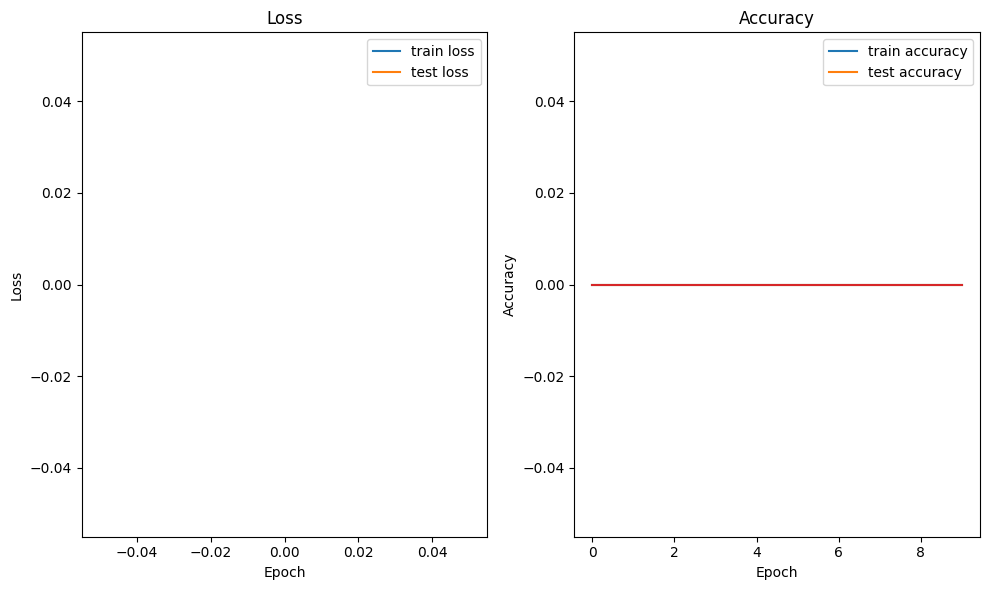

In [ ]:
# Train the best model with all available data
best_model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), callbacks=[checkpoint_cb, early_stopping_cb])

# Get the history of the best model
best_model_history = best_model.history.history

# Plot the metrics of the best model
plot_graph_3([best_model_history])

In [ ]:
type(best_model_history)
for key in (best_model_history):
  print('[key]: ', key)



[key]:  loss
[key]:  val_loss
